In [1]:
import cv2
import numpy as np

In [2]:
from PIL import Image, ImageOps, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import os

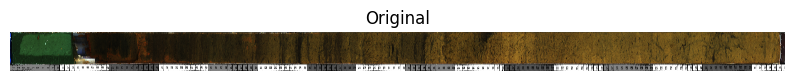

Bottom crop: 0
Left crop: 15
Right crop: 3569


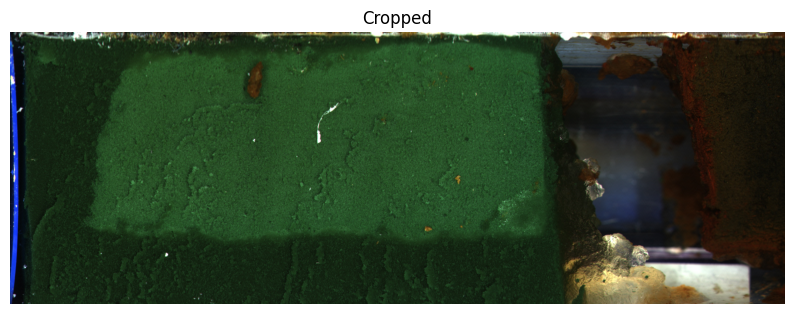

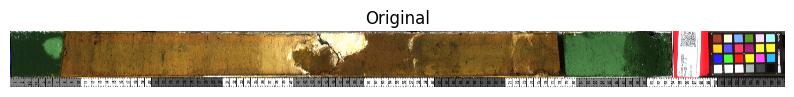

Bottom crop: 0
Left crop: 1587
Right crop: 17093


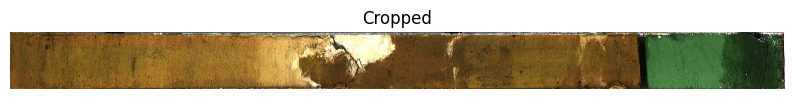

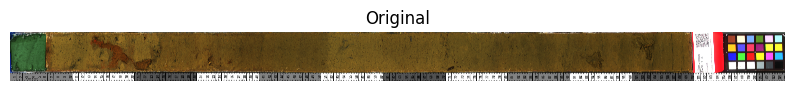

Bottom crop: 0
Left crop: 1223
Right crop: 20688


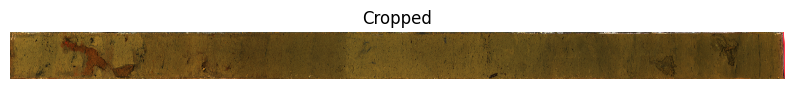

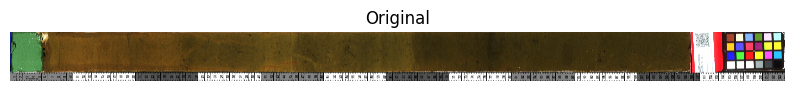

Bottom crop: 0
Left crop: 2
Right crop: 1


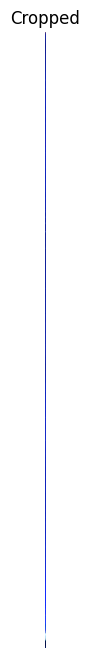

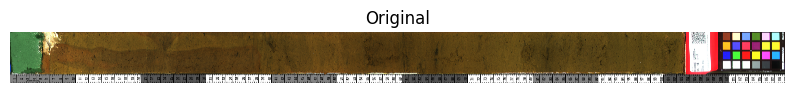

Bottom crop: 0
Left crop: 1538
Right crop: 19079


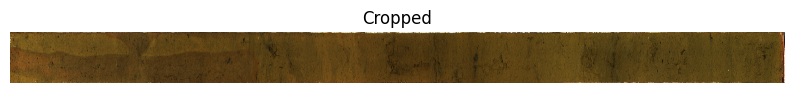

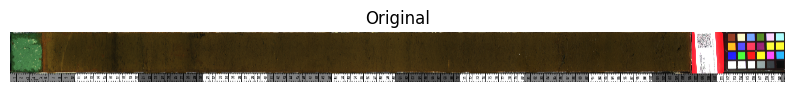

Bottom crop: 0
Left crop: 2300
Right crop: 18926


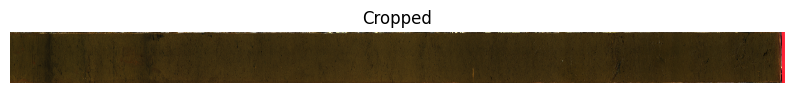

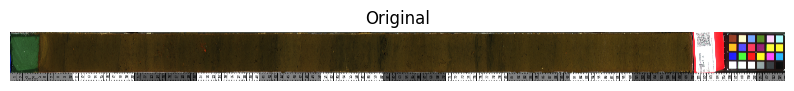

Bottom crop: 0
Left crop: 991
Right crop: 20934


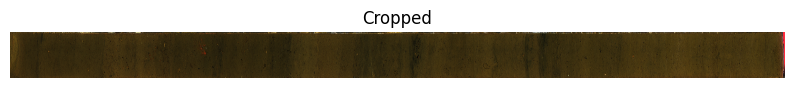

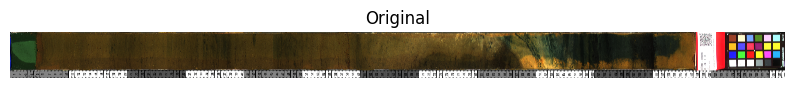

Bottom crop: 0
Left crop: 946
Right crop: 22503


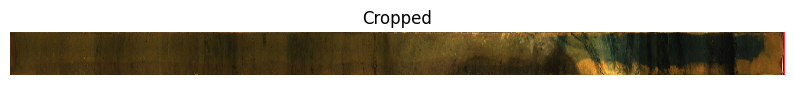

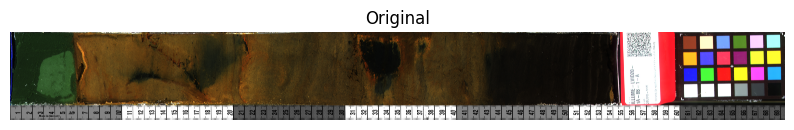

Bottom crop: 0
Left crop: 1267
Right crop: 8930


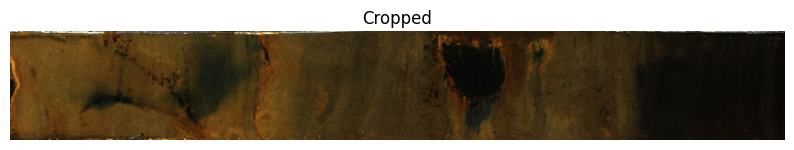

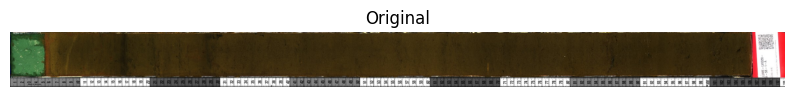

Bottom crop: 0
Left crop: 533
Right crop: 1727


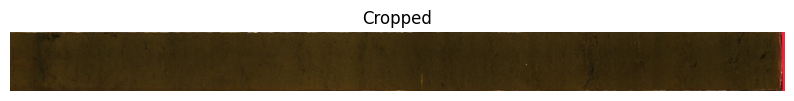

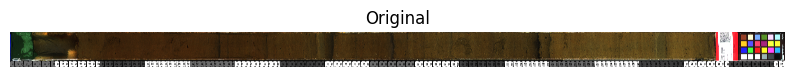

Bottom crop: 0
Left crop: 18
Right crop: 31318


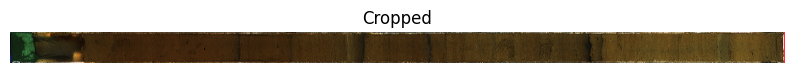

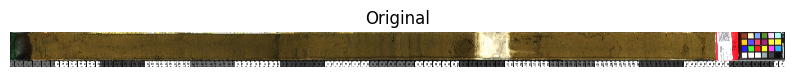

Bottom crop: 0
Left crop: 3877
Right crop: 27449


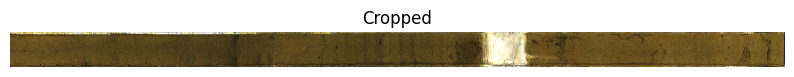

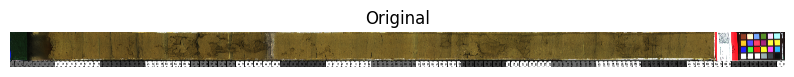

Bottom crop: 0
Left crop: 1367
Right crop: 29780


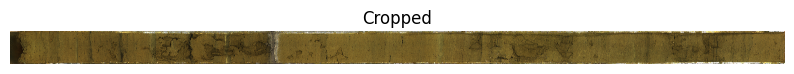

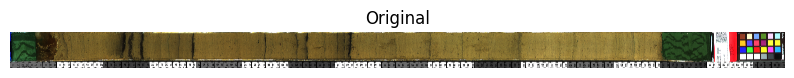

Bottom crop: 0
Left crop: 19
Right crop: 12


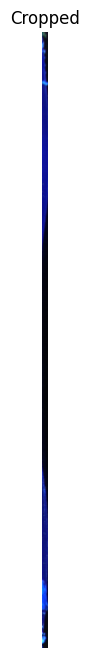

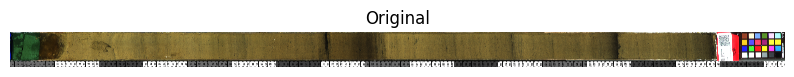

Bottom crop: 0
Left crop: 1522
Right crop: 30248


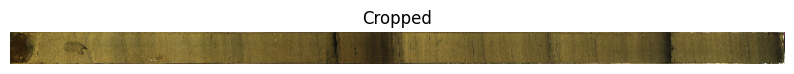

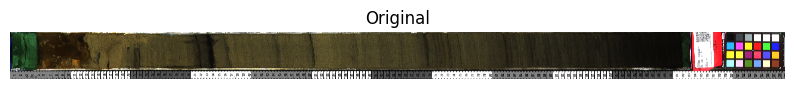

Bottom crop: 0
Left crop: 1089
Right crop: 20496


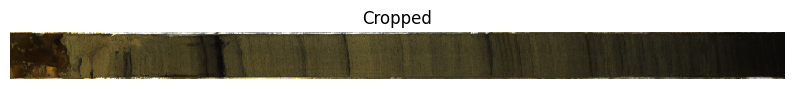

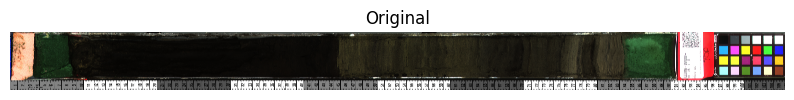

Bottom crop: 0
Left crop: 38
Right crop: 18128


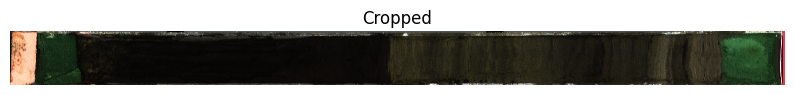

In [82]:
# color detection, promising results

def crop_sediment_core(image_path):
    with Image.open(image_path) as img:
        # convert to RGB
        img = img.convert('RGB')
        
        # image data as numpy arr
        img_array = np.array(img)
        width, height = img.size
        
        # step 1: bottom crop
        bottom_crop = int(height * 0.8)
        img = img.crop((0, 0, width, bottom_crop))
        img_array = np.array(img)
        width, height = img.size
        
        print(f"Bottom crop: {height - bottom_crop}")

        # step 2: left crop
        green_mask = (img_array[:,:,1] > img_array[:,:,0]) & (img_array[:,:,1] > img_array[:,:,2])
        green_cols = np.any(green_mask, axis=0)
        green_diff = np.diff(green_cols.astype(int))
        left_crop = np.argmax(green_diff)

        if left_crop == 1 or left_crop >= width // 2:
            left_crop = np.argmax(~green_cols)
        
        img = img.crop((left_crop, 0, width, height))
        img_array = np.array(img)
        width, height = img.size
        
        print(f"Left crop: {left_crop}")
        
        # step 3: right crop (end of brown core)
        # establish a range for brown color
        brown_mask = (
            (img_array[:,:,0] > 10) & (img_array[:,:,0] < 230) &  # R channel: from dark brown to light brown
            (img_array[:,:,1] > 40) & (img_array[:,:,1] < 150) &  # G channel: similarly ranged
            (img_array[:,:,2] < 100)                              # B channel: mostly low for brown
        )
        
        brown_cols = np.any(brown_mask, axis=0)
        brown_diff = np.diff(brown_cols.astype(int))
        right_crop = np.argmax(brown_diff)
        
        img = img.crop((0, 0, right_crop, height))
        
        print(f"Right crop: {right_crop}")
        
        return img

for filename in os.listdir('cores'):
    image_path = os.path.join('cores', filename)
    img = Image.open(image_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')
    plt.show()
    
    cropped_img = crop_sediment_core(image_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(cropped_img)
    plt.title("Cropped")
    plt.axis('off')
    plt.show()

    # if there is a little bit of blue on the left of the image, it really throws off the program 

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

In [2]:
# CNN model to automate cropping

def load_and_preprocess_data(original_dir, cropped_dir):
    originals = []
    masks = []
    
    for img_name in os.listdir(original_dir):
        orig_img = Image.open(os.path.join(original_dir, img_name))
        orig_img = orig_img.resize((25000, 1566))  # resize to a standard size
        orig_array = np.array(orig_img) / 255.0  # normalize
        
        cropped_img = Image.open(os.path.join(cropped_dir, img_name))
        cropped_img = cropped_img.resize((25000, 1566))
        
        # create binary mask, where the area to keep is 1 and the area to crop out is 0
        # was originally comparing coordinates but computer cropping tool makes images smaller dimension wise
        mask = np.zeros((1566, 25000), dtype=np.float32)
        mask[np.any(np.array(cropped_img) > 0, axis=2)] = 1
        
        originals.append(orig_array)
        masks.append(mask)
    
    return np.array(originals), np.array(masks)

def create_model():
    inputs = Input(shape=(1566, 25000, 3))
    
    # downsampling
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # upsampling
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    # ensure output has same dimensions as input
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, X_train, y_train, epochs=100, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    return history

def predict_and_visualize(model, image_path):
    img = Image.open(image_path)
    img_resized = img.resize((25000, 1566))
    img_array = np.array(img_resized) / 255.0
    
    prediction = model.predict(np.expand_dims(img_array, axis=0))[0, :, :, 0]
    
    # apply threshold to get binary mask
    mask = (prediction > 0.5).astype(np.uint8)
    
    # apply mask to original image
    cropped_img = img_resized * np.expand_dims(mask, axis=-1)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    ax1.imshow(img_resized)
    ax1.set_title('Original Image')
    
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Predicted Mask')
    
    ax3.imshow(cropped_img.astype(np.uint8))
    ax3.set_title('Cropped Image')
    
    plt.tight_layout()
    plt.show()


original_dir = "cores"
cropped_dir = "cropped"

X, y = load_and_preprocess_data(original_dir, cropped_dir)
model = create_model()
history = train_model(model, X, y)

# predict
predict_and_visualize(model, "cores/lvid-5.jpg")

Epoch 1/100


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1566, 25000), output.shape=(None, 1568, 25000)

In [5]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # downsampling
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # upsampling
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    # ensure output has same dimensions as input
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, X_train, y_train, epochs=100, batch_size=1):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    return history

def load_and_preprocess_data(original_dir, cropped_dir):
    originals = []
    masks = []
    
    for img_name in os.listdir(original_dir):
        orig_img = Image.open(os.path.join(original_dir, img_name))
        print(f"Original image size: {orig_img.size}")
        orig_array = np.array(orig_img)
        print(f"Original array shape: {orig_array.shape}")
        
        cropped_img = Image.open(os.path.join(cropped_dir, img_name))
        print(f"Cropped image size: {cropped_img.size}")
        cropped_array = np.array(cropped_img)
        print(f"Cropped array shape: {cropped_array.shape}")
        
        # create mask based on original image size
        mask = np.zeros((*orig_array.shape[:2], 1), dtype=np.float32)
        
        # resize cropped array to match original array size
        resized_cropped = np.array(Image.fromarray(cropped_array).resize(orig_img.size))
        
        mask[np.any(resized_cropped > 0, axis=2)] = 1
        print(f"Mask shape: {mask.shape}")
        
        originals.append(orig_array)
        masks.append(mask)
    
    # find the maximum dimensions
    max_height = max(img.shape[0] for img in originals)
    max_width = max(img.shape[1] for img in originals)
    
    # pad images to the maximum size
    padded_originals = []
    padded_masks = []
    for orig, mask in zip(originals, masks):
        pad_height = max_height - orig.shape[0]
        pad_width = max_width - orig.shape[1]
        padded_orig = np.pad(orig, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')
        padded_mask = np.pad(mask, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')
        padded_originals.append(padded_orig)
        padded_masks.append(padded_mask)
    
    X = np.array(padded_originals)
    y = np.array(padded_masks)
    
    print(f"Final X shape: {X.shape}")
    print(f"Final y shape: {y.shape}")
    
    return X, y

original_dir = "cores"
cropped_dir = "cropped"

X, y = load_and_preprocess_data(original_dir, cropped_dir)

X = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(y)

print(f"X tensor shape: {X.shape}")
print(f"y tensor shape: {y.shape}")

input_shape = X.shape[1:]
model = create_model(input_shape)
history = train_model(model, X, y, epochs=100, batch_size=1)

Original image size: (31237, 1566)
Original array shape: (1566, 31237, 3)
Cropped image size: (1818, 84)
Cropped array shape: (84, 1818, 3)
Mask shape: (1566, 31237, 1)
Original image size: (21837, 1566)
Original array shape: (1566, 21837, 3)
Cropped image size: (1274, 116)
Cropped array shape: (116, 1274, 3)
Mask shape: (1566, 21837, 1)
Original image size: (24837, 1566)
Original array shape: (1566, 24837, 3)
Cropped image size: (20688, 1252)
Cropped array shape: (1252, 20688, 3)
Mask shape: (1566, 24837, 1)
Original image size: (24637, 1566)
Original array shape: (1566, 24637, 3)
Cropped image size: (1658, 104)
Cropped array shape: (104, 1658, 3)
Mask shape: (1566, 24637, 1)
Original image size: (23637, 1566)
Original array shape: (1566, 23637, 3)
Cropped image size: (19079, 1252)
Cropped array shape: (1252, 19079, 3)
Mask shape: (1566, 23637, 1)
Original image size: (24037, 1566)
Original array shape: (1566, 24037, 3)
Cropped image size: (18926, 1252)
Cropped array shape: (1252, 189

ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(1, 1566, 34813, 1), output.shape=(1, 1568, 34816, 1)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim  

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # downsampling
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, padding=1)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, padding=1)
        
        # upsampling
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)

        self.conv7 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2)

        # ensure output has same dimensions as input
        self.conv9 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(32, 1, kernel_size=1, padding=0)

    def forward(self, x):
        # downsampling
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool1(x)

        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.pool2(x)
        
        # upsampling
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = self.upsample1(x)

        x = torch.relu(self.conv7(x))
        x = torch.relu(self.conv8(x))
        x = self.upsample2(x)
        
        x = torch.relu(self.conv9(x))
        x = torch.sigmoid(self.conv_out(x))  # Use sigmoid for binary segmentation
        return x

# training loop using PyTorch
def train_model(model, X_train, y_train, epochs=100, batch_size=1):
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()
        
        # shuffle the data each epoch
        permutation = torch.randperm(X_train.size(0))
        for i in range(0, X_train.size(0), batch_size):
            optimizer.zero_grad()

            indices = permutation[i:i+batch_size]
            batch_X, batch_y = X_train[indices], y_train[indices]

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

# data loading and preprocessing without resizing
def load_and_preprocess_data(original_dir, cropped_dir):
    originals = []
    masks = []
    
    for img_name in os.listdir(original_dir):
        orig_img = Image.open(os.path.join(original_dir, img_name))
        #print(f"Original image size: {orig_img.size}")
        orig_array = np.array(orig_img)
        #print(f"Original array shape: {orig_array.shape}")
        
        cropped_img = Image.open(os.path.join(cropped_dir, img_name))
        #print(f"Cropped image size: {cropped_img.size}")
        cropped_array = np.array(cropped_img)
        #print(f"Cropped array shape: {cropped_array.shape}")
        
        # create mask
        mask = np.zeros((*orig_array.shape[:2], 1), dtype=np.float32)
        resized_cropped = np.array(Image.fromarray(cropped_array).resize(orig_img.size))
        mask[np.any(resized_cropped > 0, axis=2)] = 1
        #print(f"Mask shape: {mask.shape}")
        
        originals.append(orig_array)
        masks.append(mask)
    
    max_height = max(img.shape[0] for img in originals)
    max_width = max(img.shape[1] for img in originals)
    
    # pad images to the maximum size
    padded_originals = []
    padded_masks = []
    for orig, mask in zip(originals, masks):
        pad_height = max_height - orig.shape[0]
        pad_width = max_width - orig.shape[1]
        padded_orig = np.pad(orig, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')
        padded_mask = np.pad(mask, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')
        padded_originals.append(padded_orig)
        padded_masks.append(padded_mask)
    
    X = np.array(padded_originals) / 255.0 
    y = np.array(padded_masks)
    
    print(f"Final X shape: {X.shape}")
    print(f"Final y shape: {y.shape}")
    
    X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2) 
    y = torch.tensor(y, dtype=torch.float32).permute(0, 3, 1, 2)
    
    return X, y

original_dir = "cores"
cropped_dir = "cropped"

X, y = load_and_preprocess_data(original_dir, cropped_dir)

model = Autoencoder().cuda() if torch.cuda.is_available() else Autoencoder()
train_model(model, X.cuda() if torch.cuda.is_available() else X, 
            y.cuda() if torch.cuda.is_available() else y, epochs=100, batch_size=1)

def predict_and_visualize(model, image_path):
    model.eval()
    
    # load image and convert to tensor
    img = Image.open(image_path)
    img_array = np.array(img) / 255.0
    img_tensor = torch.tensor(img_array, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Add batch dimension
    
    img_tensor = img_tensor.cuda() if torch.cuda.is_available() else img_tensor
    prediction = model(img_tensor).cpu().detach().numpy()[0, 0, :, :]
    
    mask = (prediction > 0.5).astype(np.uint8)
    
    # mask on original image
    cropped_img = img_array * np.expand_dims(mask, axis=-1)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    ax1.imshow(img_array)
    ax1.set_title('Original Image')
    
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Predicted Mask')
    
    ax3.imshow(cropped_img)
    ax3.set_title('Cropped Image')
    
    plt.tight_layout()
    plt.show()

predict_and_visualize(model, "cores/lvid-5.jpg")

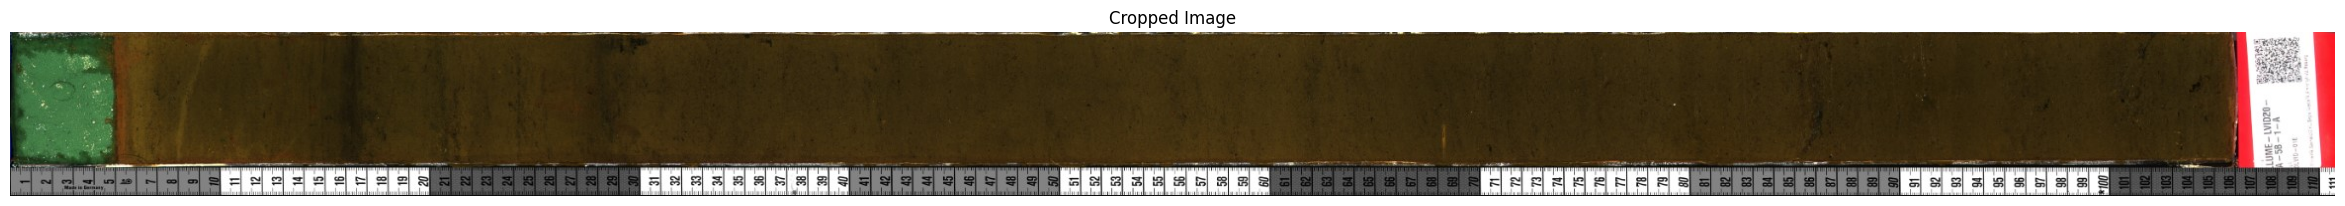

In [45]:
# working with Will's code (4-26 check)

def process_and_display_image(image):
    if isinstance(image, str):
        image = cv2.imread(image)
    elif not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Convert to grayscale
    gray = np.mean(image, axis=2).astype(np.uint8)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive Thresholding
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Morphological Closing to fill gaps
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Assume the largest contour is the sediment
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_image = image[y:y+h, x:x+w]

        # Display the cropped image
        plt.figure(figsize=(30, 9))
        plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        plt.title('Cropped Image')
        plt.axis('off')
        plt.show()
  
        return cropped_image
    else:
        print("No contours found")
        return None

cropped_image = process_and_display_image('cores/svid-2.jpg')


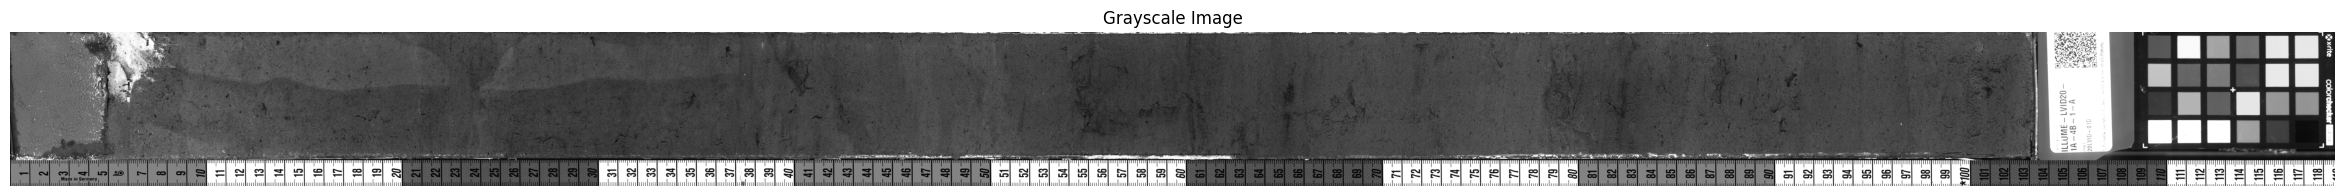

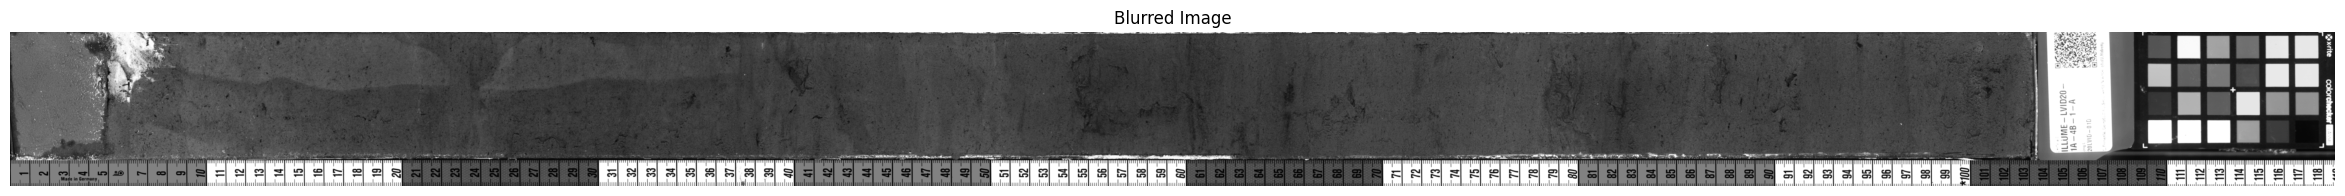

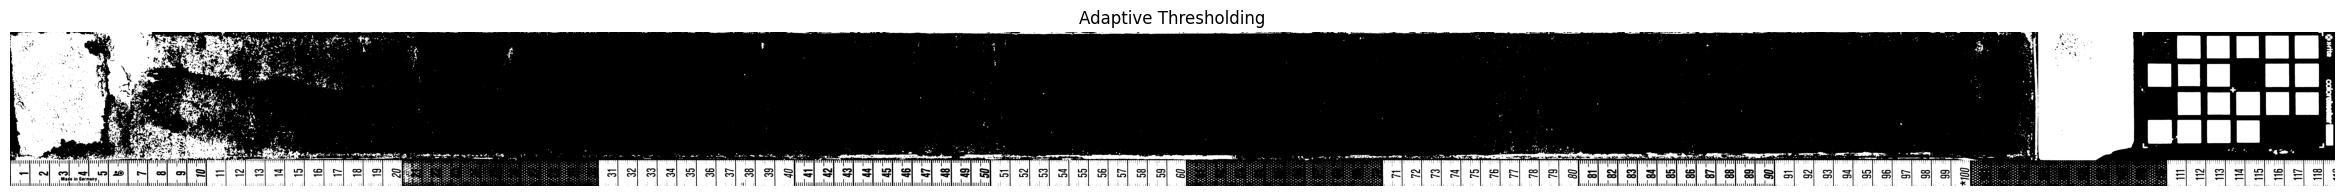

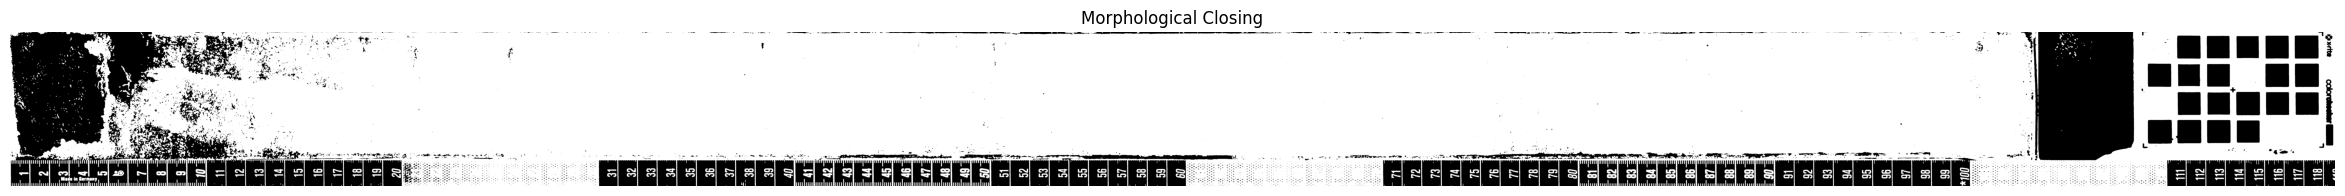

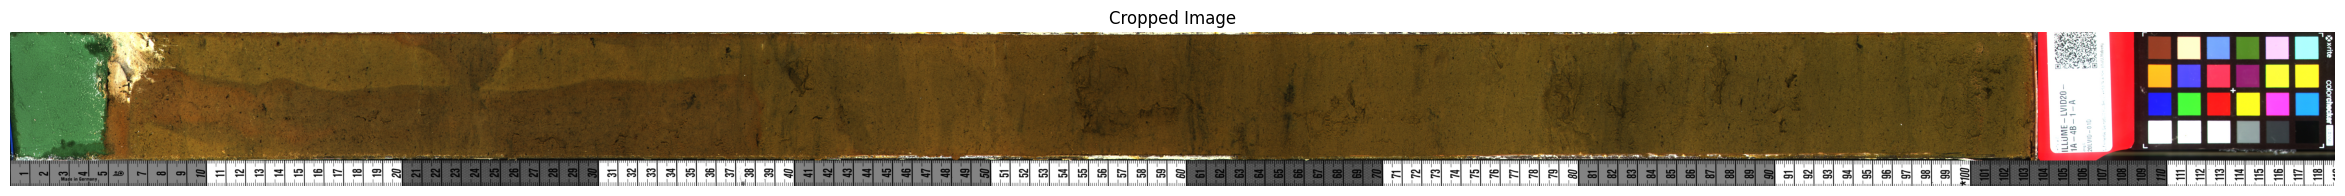

In [4]:
def process_and_display_image(image):
    gray_image = image.convert('L')
    plt.figure(figsize=(30, 9))
    plt.imshow(gray_image, cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')
    plt.show()

    blurred_image = gray_image.filter(ImageFilter.GaussianBlur(radius=2))
    plt.figure(figsize=(30, 9))
    plt.imshow(blurred_image, cmap='gray')
    plt.title('Blurred Image')
    plt.axis('off')
    plt.show()

    blurred_array = np.array(blurred_image)

    thresholded_array = np.where(blurred_array > blurred_array.mean(), 255, 0).astype(np.uint8)
    plt.figure(figsize=(30, 9))
    plt.imshow(thresholded_array, cmap='gray')
    plt.title('Adaptive Thresholding')
    plt.axis('off')
    plt.show()

    closed_image = ImageOps.invert(Image.fromarray(thresholded_array))
    closed_image = closed_image.filter(ImageFilter.MinFilter(size=3)).filter(ImageFilter.MaxFilter(size=5))
    closed_array = np.array(closed_image)
    plt.figure(figsize=(30, 9))
    plt.imshow(closed_array, cmap='gray')
    plt.title('Morphological Closing')
    plt.axis('off')
    plt.show()

    contours = np.argwhere(closed_array == 0) 

    if contours.size > 0:
        min_x, min_y = contours.min(axis=0)
        max_x, max_y = contours.max(axis=0)
        cropped_image = image.crop((min_y, min_x, max_y, max_x)) 
        
        plt.figure(figsize=(30, 9))
        plt.imshow(cropped_image)
        plt.title('Cropped Image')
        plt.axis('off')
        plt.show()

        return cropped_image

image = Image.open('cores/lvid-5.jpg')
cropped_image = process_and_display_image(image)
